# Walmart sales

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score

In [2]:
df_sales = pd.read_csv('data/Walmart_Store_sales.csv')

In [3]:
df_sales

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
...,...,...,...,...,...,...,...,...
145,14.0,18-06-2010,2248645.59,0.0,72.62,2.780,182.442420,8.899
146,7.0,NaN,716388.81,NaN,20.74,2.778,NaN,NaN
147,17.0,11-06-2010,845252.21,0.0,57.14,2.841,126.111903,NaN
148,8.0,12-08-2011,856796.10,0.0,86.05,3.638,219.007525,NaN


## EDA

# idées à tracer :
## corrélations :
- matrice de corrélation
- weekly sales fonction de :
    - store (histogramme, en moyenne et écart type)
    - mois de l'année (idem)
    - holiday (idem)
    - temperature (scatter)
    - fuel price (scatter)
    - CPI (scatter)
    - unemployment (scatter)

### Observations :

Let's count the number of appearances of each store, to check if the dataset is balanced or not :

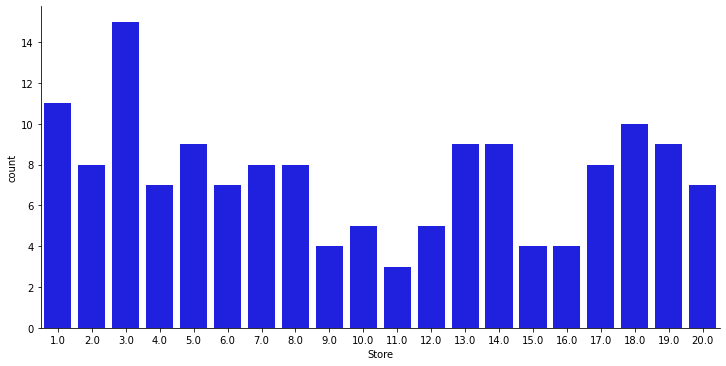

In [4]:
sns.catplot(data = df_sales, x = 'Store', kind = 'count', color = 'b', aspect = 2)
plt.show()

The dataset is not very balanced ... The store number 11 appears only 3 times for example. Let's observe with a violin graph :

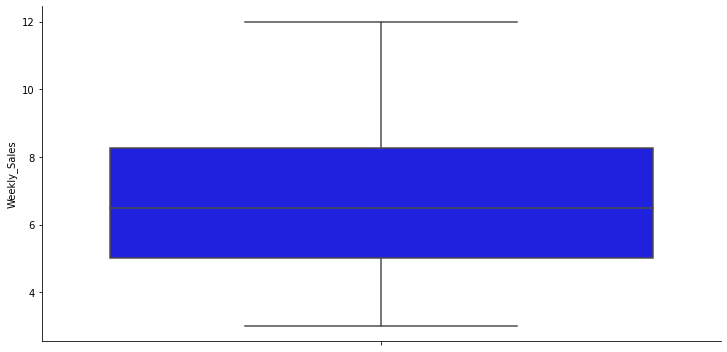

In [5]:
sns.catplot(data = df_sales.groupby('Store').count(), y = 'Weekly_Sales', kind = 'box', color = 'b', aspect = 2)
plt.show()

The number of appearances of each store goes from 3 to 12, with a median around 7.

The target is "Weekly Sales", let's look how its values are distributed :

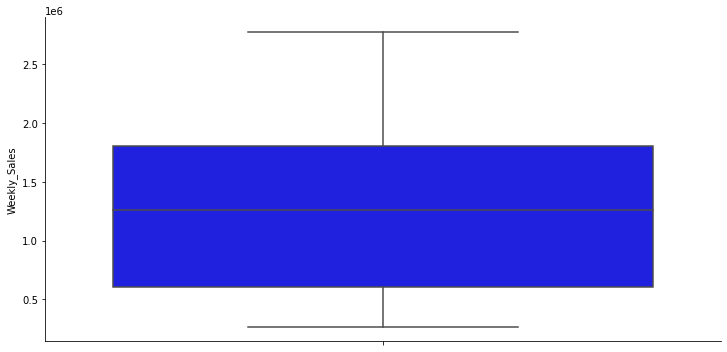

In [6]:
sns.catplot(data = df_sales, y = 'Weekly_Sales', kind = 'box', color = 'b', aspect = 2)
plt.show()

In [7]:
df_sales.Weekly_Sales.describe()

count    1.360000e+02
mean     1.249536e+06
std      6.474630e+05
min      2.689290e+05
25%      6.050757e+05
50%      1.261424e+06
75%      1.806386e+06
max      2.771397e+06
Name: Weekly_Sales, dtype: float64

There are some days with vacations, we would like to know how the data is balanced between days with vacations and days without :

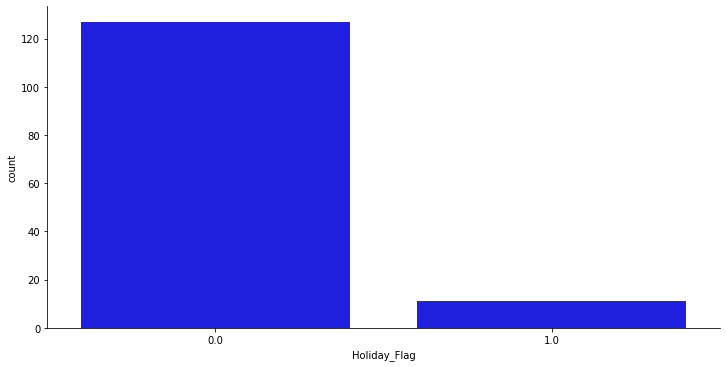

In [8]:
sns.catplot(data = df_sales, x = 'Holiday_Flag', kind = 'count', color = 'b', aspect = 2)
plt.show()

As expected, the dataset is very much unbalanced. Does holidays have an impact on sales ?

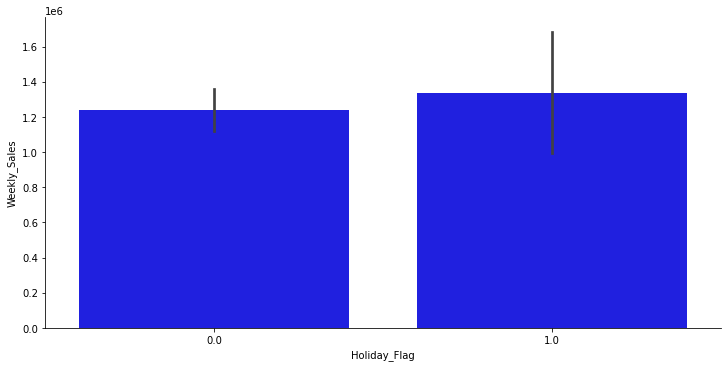

In [9]:
sns.catplot(data = df_sales, x = 'Holiday_Flag', y = 'Weekly_Sales', kind = 'bar',  color = 'b', aspect = 2)
plt.show()

We have no evidence of impact of holydays on sales : average values are close and confidence intervals are large, especially regarding holidays for which data is scarce.

Now we would like to observe the Fuel_Price values, and its potential impact on sales :

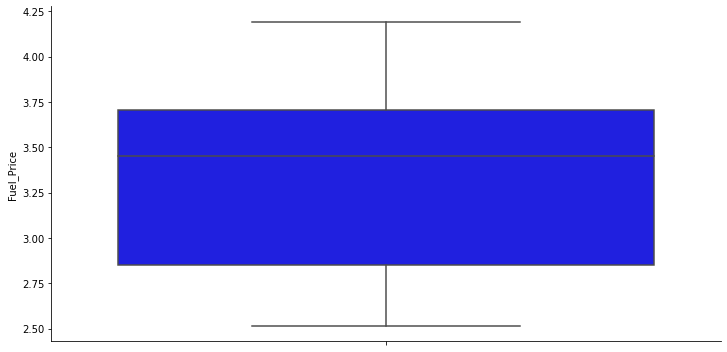

In [10]:
sns.catplot(data = df_sales, y = 'Fuel_Price', kind = 'box', color = 'b', aspect = 2)
plt.show()

In [11]:
df_temp = df_sales.copy()
df_temp['datetime'] = pd.to_datetime(df_temp['Date'])
df_temp['year'] = df_temp['datetime'].dt.year

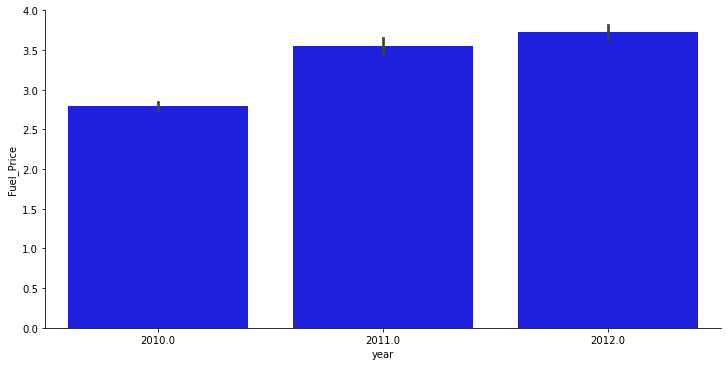

In [12]:
sns.catplot(data = df_temp, x = 'year', y = 'Fuel_Price', color = 'b', kind = 'bar', aspect = 2)
plt.show()

Impact on fuel price between 2010 and 2011. Hard to say between 2011 and 2012 given confidence intervals.

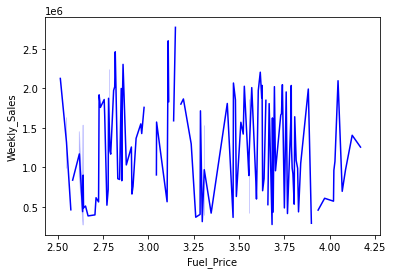

In [13]:
sns.lineplot(data = df_sales, x = 'Fuel_Price', y = 'Weekly_Sales', color = 'b')
plt.show()

Hard to say if we have an impact of fuel price on sales..

Finally let's look at distribution of CPI and Unemployment :

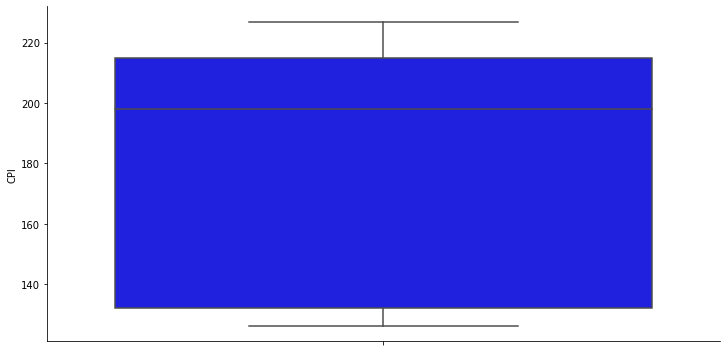

In [14]:
sns.catplot(data = df_sales, y = 'CPI', kind = 'box', color = 'b', aspect = 2)
plt.show()

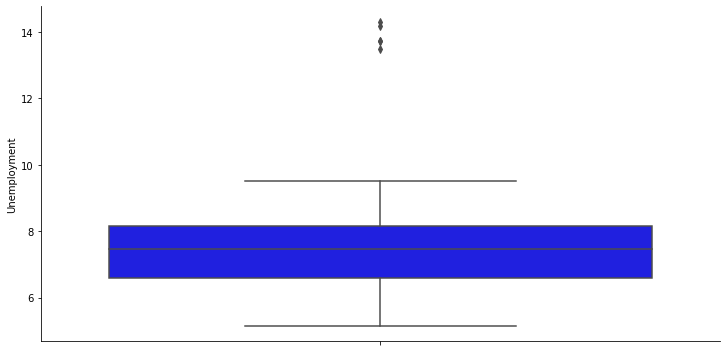

In [15]:
sns.catplot(data = df_sales, y = 'Unemployment', kind = 'box', color = 'b', aspect = 2)
plt.show()

### Correlations :

We will calculate a correlation matrix to see if we find quick similarities among the data.

In [16]:
corr = df_sales.corr()
corr = corr.abs()

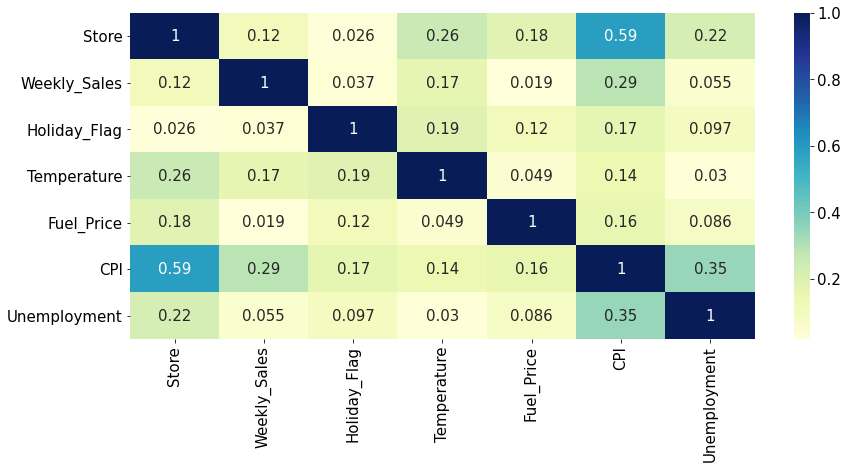

In [17]:
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size': 15})

sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

Feature most correlated with 'Weekly_Sales' are :
- CPI (Consumer Price Index : measurement of the price of living)
- Temperature (indirect measurement of period of year ?)
- Store

We also see that there is a certain correlation between Store and CPI. As we saw earlier, there are no much values for each store, but let's take a look at distribution of CPI for each store :

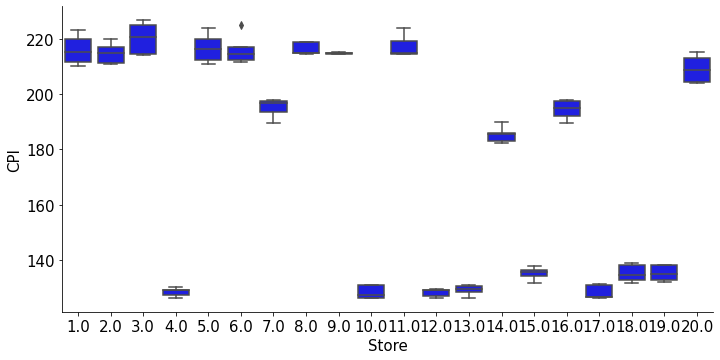

In [18]:
sns.catplot(data = df_sales, x = 'Store', y = 'CPI' , color = 'b', kind = 'box', aspect = 2)
plt.show()

As CPI is a measure of price of living, we can imagine that the different stores are in different areas, far enough to each other to impact price of living (maybe in different states).
Or maybe it is another hidden data, it is difficult to say.

#### CPI impact on weekly sales :

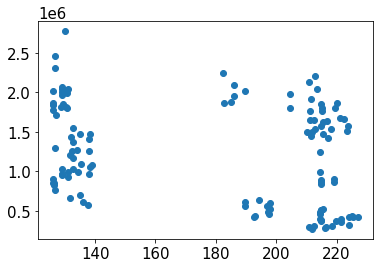

In [19]:
plt.scatter(df_sales['CPI'] , df_sales['Weekly_Sales'],  )
plt.show()

We see different "groups" of CPI values, let's split them in two groups : less of more than 170 :

In [20]:
def categorize_cpi(cpi) :
    if cpi < 170 :
        return 'inf 170'
    else :
        return 'sup 170'

df_temp['CPI_category'] = df_temp['CPI'].apply(categorize_cpi)

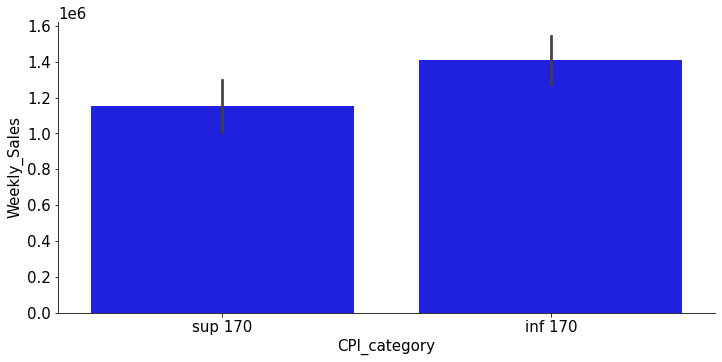

In [21]:
sns.catplot(data = df_temp, x = 'CPI_category', y = 'Weekly_Sales' , color = 'b', kind = 'bar', aspect = 2)
plt.show()

Not much to say given confidence intervals.

#### Temperature impact on weekly sales :

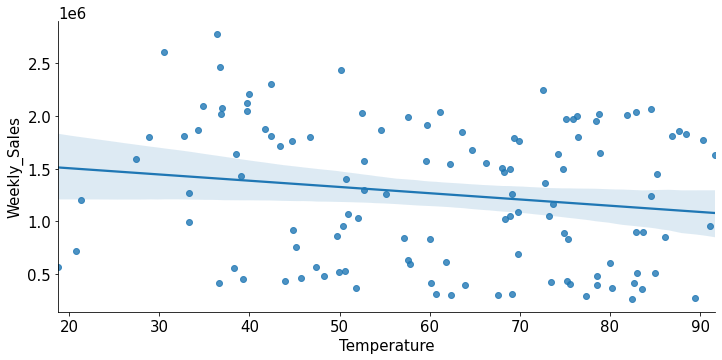

In [22]:
sns.lmplot(data = df_temp, x = 'Temperature', y = 'Weekly_Sales' , aspect = 2)
plt.show()

Again, hard to find a rule.

#### Store impact on weekly sales :

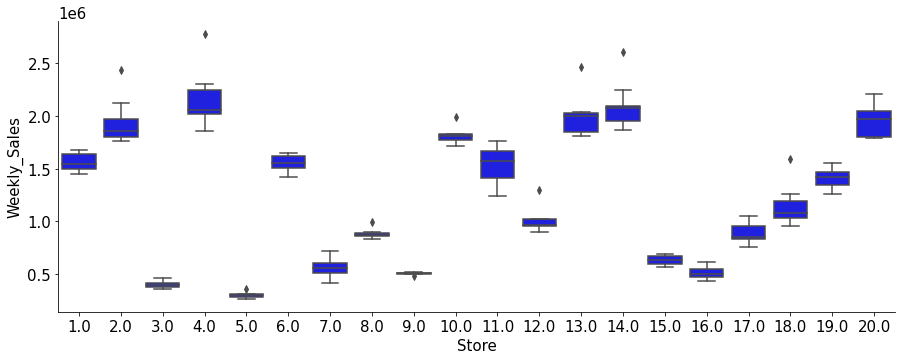

In [23]:
sns.catplot(data = df_sales, x = 'Store', y = 'Weekly_Sales', color = 'b', kind = 'box', aspect = 2.5)
plt.show()

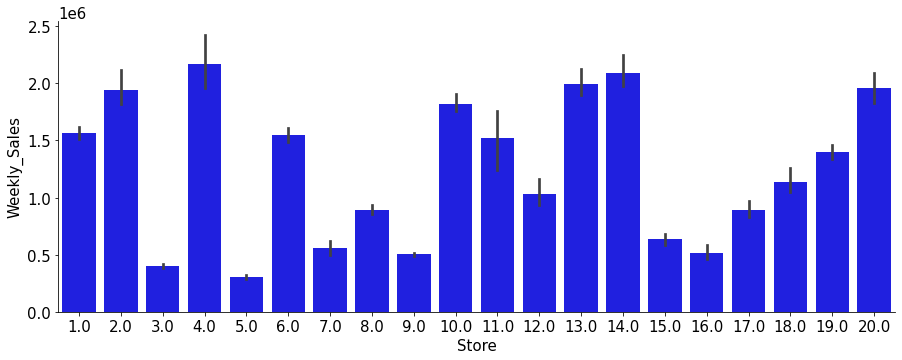

In [24]:
sns.catplot(data = df_sales, x = 'Store', y = 'Weekly_Sales', color = 'b', kind = 'bar', aspect = 2.5)
plt.show()

Even if we do not have many values for each store, we can see here some disparity of weekly sales.

Some stores perform way better than others.

It could be interesting to get more datas about stores : their size, location, etc.

## Linear regression

### Dealing with missing values

As we can see, we have some missing values :

In [25]:
df_sales.isnull().sum(axis = 0)

Store            0
Date            18
Weekly_Sales    14
Holiday_Flag    12
Temperature     18
Fuel_Price      14
CPI             12
Unemployment    15
dtype: int64

Let's describe how we will procede for each column :
- Store            0   ->   No missing value, nothing to do here
- Date            18   ->   As this is a date, the best choice seems to delete lines where they appear (it seems difficult to choose a value to impute)
- Weekly_Sales    14   ->   It is the result we try to predict, so we should just delete the lines with na
- Holiday_Flag    12   ->   Delete na values
- Temperature     18   ->   Average
- Fuel_Price      14   ->   Average
- CPI             12   ->   Average
- Unemployment    15   ->   Average

Firstly let's delete lines where Date / Weekly sales / Holiday_Flag are missing :

In [26]:
df_sales = df_sales[df_sales['Date'].notna()]
df_sales = df_sales[df_sales['Weekly_Sales'].notna()]
df_sales = df_sales[df_sales['Holiday_Flag'].notna()]

In [27]:
df_sales.isnull().sum(axis = 0)

Store            0
Date             0
Weekly_Sales     0
Holiday_Flag     0
Temperature     11
Fuel_Price      11
CPI              9
Unemployment    11
dtype: int64

We will deal with the rest with average imputer.

It could be interesting to extract a 'date timestamp' and the 'day of the week' instead of the 'Date' feature :

In [28]:
df_sales.Date = pd.to_datetime(df_sales.Date)
df_sales['Date_timestamp'] = df_sales.Date.values.astype(np.int64) // 10 ** 9
df_sales['Day_of_week'] = pd.DatetimeIndex(df_sales['Date']).dayofweek
df_sales = df_sales.drop('Date', axis = 1)

In [29]:
df_sales.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Date_timestamp,Day_of_week
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,1301011200,4
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,1275004800,4
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,1275004800,4
6,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,1299369600,6
7,20.0,2203523.20,0.0,39.93,3.617,213.023623,6.961,1330646400,4


### Preprocessing

Firstly let's separate features from target :

In [30]:
X = df_sales.drop('Weekly_Sales', axis = 1)
y = df_sales['Weekly_Sales']

In [31]:
X.head()

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Date_timestamp,Day_of_week
1,13.0,0.0,42.38,3.435,128.616064,7.470,1301011200,4
4,6.0,0.0,78.89,2.759,212.412888,7.092,1275004800,4
5,4.0,0.0,NaN,2.756,126.160226,7.896,1275004800,4
6,15.0,0.0,69.80,4.069,134.855161,7.658,1299369600,6
7,20.0,0.0,39.93,3.617,213.023623,6.961,1330646400,4


In [32]:
y.head()

1    1807545.43
4    1644470.66
5    1857533.70
6     695396.19
7    2203523.20
Name: Weekly_Sales, dtype: float64

In [33]:
# numeric features are : Temperature, Fuel_Price, CPI, Unemployment, Date_timestamp
numeric_features = [2, 3, 4, 5, 6]

# categorical features are : Store, Holiday_Flag, Day_of_week
categorical_features = [0, 1, 7]

# transformers creation
numeric_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('scaler', OneHotEncoder(drop = 'first'))
    ])



In [34]:
# creation of train and test sets :

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, train_size = 0.8)

<b>Imputing values for Fuel_Price :</b>

In [35]:
X_train.head()

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Date_timestamp,Day_of_week
35,19.0,0.0,33.26,3.789,133.958742,7.771,1301011200,4
127,16.0,0.0,61.79,2.711,189.523128,6.868,1283817600,1
44,1.0,1.0,38.51,2.548,211.242170,8.106,1291248000,3
6,15.0,0.0,69.80,4.069,134.855161,7.658,1299369600,6
95,1.0,0.0,74.78,2.854,210.337426,7.808,1273795200,4


In [36]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features), 
        ('cat', categorical_transformer, categorical_features)
    ]
    )

In [37]:
X_train = preprocessor.fit_transform(X_train)

In [38]:
X_train

<87x30 sparse matrix of type '<class 'numpy.float64'>'
	with 590 stored elements in Compressed Sparse Row format>

In [39]:
X_test = preprocessor.transform(X_test)

### Linear model creation and Machine Learning

In [40]:
regressor = LinearRegression()

In [41]:
regressor.fit(X_train, y_train)

LinearRegression()

In [42]:
y_train_prediction = regressor.predict(X_train)
y_test_prediction = regressor.predict(X_test)

In [43]:
r2_score(y_train, y_train_prediction)

0.9718387172453121

In [44]:
r2_score(y_test, y_test_prediction)

0.8531348059686112

Resluts are ok in absolute on test score but we have a strong overfitting when comparing R2 score on train and test datasets.

We will now try to show the most important features by showing coefficients of the linear model.

As the data was normalized, we can compare the coefficients. The more the absolute value of coefficient is high, the more the feature has strong impact on the model result.

In [45]:
preprocessor.transformers_[1][1][1].categories_

[array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 array([0., 1.]),
 array([0., 1., 3., 4., 5., 6.])]

In [46]:
# we define categorical names :

categorical_column_names = [*range(2, 20)] + ['holyday'] + ['tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
len(categorical_column_names)

25

In [47]:
numerical_column_names = X.iloc[:, numeric_features].columns # using the .columns attribute gives us the name of the column 
print("numerical columns are: ", numerical_column_names)

numerical columns are:  Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Date_timestamp'], dtype='object')


In [48]:
all_column_names = np.append(numerical_column_names, categorical_column_names)
all_column_names

array(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'Date_timestamp', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', 'holyday',
       'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'],
      dtype=object)

In [49]:
len(regressor.coef_.squeeze())

30

In [50]:
len(all_column_names)

30

In [51]:
# Feature importance 
feature_importance = pd.DataFrame({
    "feature_names": all_column_names,
    "coefficients":regressor.coef_.squeeze()                                     
})

In [52]:
feature_importance

,feature_names,coefficients
0,Temperature,-5.442707e+04
1,Fuel_Price,-7.434959e+04
2,CPI,-5.231552e+04
3,Unemployment,-4.169296e+04
4,Date_timestamp,2.723611e+04
5,2,2.995554e+05
6,3,-1.235654e+06
7,4,5.573026e+05
8,5,-1.271412e+06
9,6,2.381795e+04


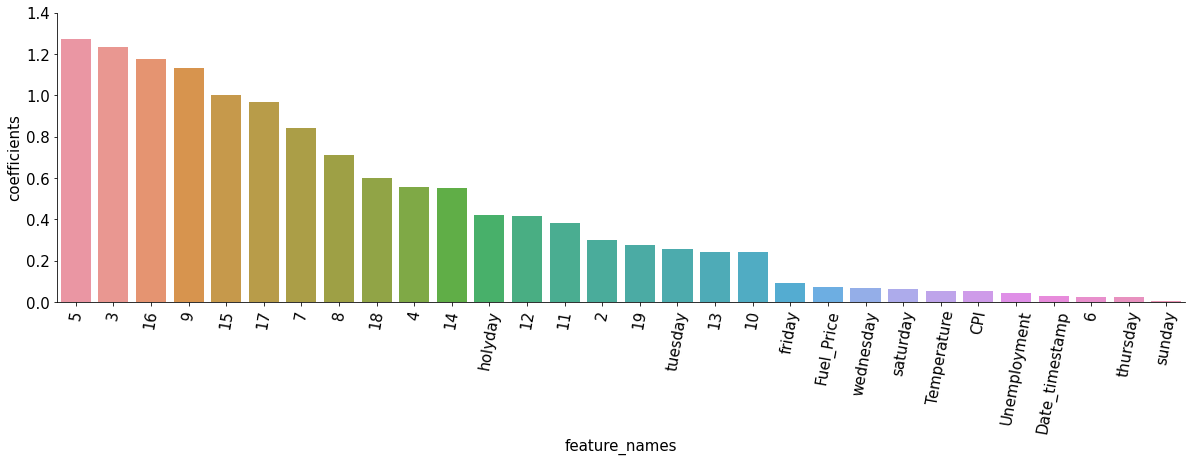

In [53]:
feature_importance.coefficients = feature_importance.coefficients.abs()

# Visualize ranked features using seaborn
ax = sns.catplot(x="feature_names", 
            y="coefficients", 
            data=feature_importance.sort_values(by="coefficients", ascending=False), 
            kind="bar",
            aspect=30/9) # Resize graph

ax.set_xticklabels(rotation=80, fontdict = {'fontsize':15})
ax.set_yticklabels(fontdict = {'fontsize':15})


Most important features seem to be the store id. This result is consistent with what we saw in EDA.

But like this it does not say much, knowing more about stores would be precious.

## Linear regression with Ridge

In [55]:
ridge_regressor = Ridge()

In [56]:
ridge_regressor.fit(X_train, y_train)

Ridge()

In [57]:
y_train_pred_ridge = ridge_regressor.predict(X_train)
y_test_pred_ridge = ridge_regressor.predict(X_test)

In [58]:
r2_score(y_train, y_train_pred_ridge)

0.9251512710229622

In [59]:
r2_score(y_test, y_test_pred_ridge)

0.7014410421870124

In [109]:
# hyperparameter optimization

regressor = Ridge()
# Grid of values to be tested
params = {
    'alpha': [0.0001 * i + 0.04 for i in range(100)] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 4) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid={'alpha': [0.04, 0.040100000000000004, 0.0402, 0.0403,
                                   0.0404, 0.0405, 0.040600000000000004, 0.0407,
                                   0.0408, 0.0409, 0.041, 0.0411, 0.0412,
                                   0.0413, 0.0414, 0.0415, 0.0416, 0.0417,
                                   0.041800000000000004, 0.0419, 0.042, 0.0421,
                                   0.0422, 0.042300000000000004, 0.0424, 0.0425,
                                   0.0426, 0.0427, 0.0428, 0.0429, ...]})

In [110]:
gridsearch.best_params_

{'alpha': 0.0441}

In [111]:
Y_train_pred_ridge_grid = gridsearch.predict(X_train)
Y_test_pred_ridge_grid = gridsearch.predict(X_test)

In [112]:
r2_score(y_train, Y_train_pred_ridge_grid)

0.9712127183746134

In [113]:
r2_score(y_test, Y_test_pred_ridge_grid)

0.8362724634526024

With simple linear model we had following R2 scores :
- train : 0.9718
- test : 0.8531

With Ridge, we did not perform better, as results on test sample are worse.

## Linear regression with Lasso

In [62]:
lasso_regressor = Lasso()

In [63]:
lasso_regressor.fit(X_train, y_train)

Lasso()

In [64]:
y_train_pred_lasso = lasso_regressor.predict(X_train)
y_test_pred_lasso = lasso_regressor.predict(X_test)

In [65]:
r2_score(y_train, y_train_pred_lasso)

0.9718387131892221

In [66]:
r2_score(y_test, y_test_pred_lasso)

0.8531214313619875

In [99]:
# hyperparameter optimization

regressor = Lasso()
# Grid of values to be tested
params = {
    'alpha': [0.1 * i + 770 for i in range(100)] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 4) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=Lasso(),
             param_grid={'alpha': [770.0, 770.1, 770.2, 770.3, 770.4, 770.5,
                                   770.6, 770.7, 770.8, 770.9, 771.0, 771.1,
                                   771.2, 771.3, 771.4, 771.5, 771.6, 771.7,
                                   771.8, 771.9, 772.0, 772.1, 772.2, 772.3,
                                   772.4, 772.5, 772.6, 772.7, 772.8, 772.9, ...]})

In [100]:
gridsearch.best_params_

{'alpha': 773.8}

In [101]:
Y_train_pred_lasso_grid = gridsearch.predict(X_train)
Y_test_pred_lasso_grid = gridsearch.predict(X_test)

In [102]:
r2_score(y_train, Y_train_pred_lasso_grid)

0.9701734297866583

In [103]:
r2_score(y_test, Y_test_pred_lasso_grid)

0.8553369614592178

With simple linear model we had following R2 scores :
- train : 0.9718
- test : 0.8531

With Lasso, we perform a little bit better.
If we had more time we could work again on preprocessing and feature engineering in order to reduce overfitting again.